# Linear Regression

Two examples illustrating linear regression (single variable) and multiple linear regression.

## Example 1: Space Shuttle Challenger

For background, see the [Challenger Data page on randomservices.org](http://www.randomservices.org/random/data/Challenger.html). Objective here is to understand the relationship between Temperature and the Index of O-ring damage (the "Challenger data 2" dataset).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

### Load Data

This is data collected for 23 space shuttle launches and the index of O-ring damage.

In [2]:
try:
    oring_df = pd.read_csv("Challenger2.txt", sep='\t')
except:
    oring_df = pd.read_csv("http://www.randomservices.org/random/data/Challenger2.txt", sep='\t')
    oring_df.to_csv("Challenger2.txt", sep='\t')
oring_df.head()

,T,I
0,53,11
1,57,4
2,58,4
3,63,2
4,66,0


### Plot data

From the plot, it appears that O-ring damage is more likely at lower temperatures. All launches that had no damage were on warmer days, and all launches on colder days had damage.

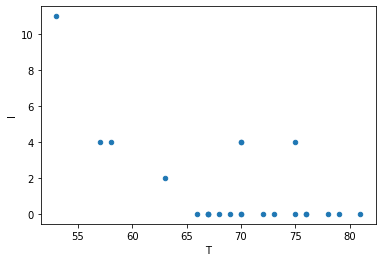

In [3]:
oring_df.plot.scatter(x="T", y="I")

### Linear Regression with single variable

We want to predict damage based on temperature.

Information returned by the summary:
* coefficient of T (slope): -0.2434
* constant intercept: 18.3651
* standard deviation for marginal distribution for slope: 0.063
* for frequentists, if we want to do a significance test of the slope values, the t-values (t) and the p-values associated with them: (-3.833, 0.001) and (4.138, 0.000).
* R-squared error: 0.412

In [4]:
# add a column of 1's for the constant
x = oring_df["T"].values
X = np.vstack((x, np.ones(len(x)))).T

y = oring_df["I"].values

print(X.shape, y.shape)

(23, 2) (23,)


In [5]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     14.69
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           0.000968
Time:                        16:25:48   Log-Likelihood:                -48.672
No. Observations:                  23   AIC:                             101.3
Df Residuals:                      21   BIC:                             103.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2434      0.063     -3.833      0.001      -0.375      -0.111
const         18.3651      4.439      4.138      0.000       9.135      27.596
==============================================================================
Omnibus:                        7.558   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                5.542
Skew:                           1.152   Prob(JB):                       0.0626
Kurtosis:                       3.687   Cond. No.                         708.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot fitted line

Best fit line shows that as the temperature gets colder by about 4 degrees, there is an increase in 1 unit of damage.

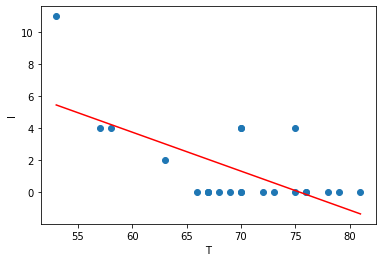

In [6]:
plt.scatter(x, y)
plt.xlabel("T")
plt.ylabel("I")

y_pred = -0.2434 * x + 18.3651
plt.plot(x, y_pred, color='r')

plt.show()

### 95% posterior probability for slope

We can also calculate the 95% posterior probability for the slope. Marginal distribution for slope is a t-distribution with 21 degrees of freedom, and has the scaling factor of the standard error.

Since the range does not pass through 0, we can definitely conclude a negative relationship.

Also note that the summary reports these bounds as well.

In [7]:
slope_lb = -0.2434 - 0.063 * stats.t.ppf(0.975, 21)
slope_ub = -0.2434 + 0.063 * stats.t.ppf(0.975, 21)
(slope_lb, slope_ub)

(-0.3744156722178427, -0.11238432778215729)

### Predictions

Predicted O-ring damage for Challenger launch, where T was 31 F.

In [8]:
y_pred = -0.2434 * 31 + 18.3651
y_pred

10.819700000000001

Or, alternatively, using vector arithmetic.

In [9]:
y_pred = np.dot(results.params, np.array([31, 1]))
y_pred

10.820515873015871

### 95% posterior probability for prediction at T=31

Apparently [hidden functionality in statsmodels](https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels).

The 95% posterior probability for the distribution of predictions is given by the `obs_ci_lower` and `obs_ci_upper` columns below.

In [10]:
predictions = results.get_prediction([31, 1])
predictions.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,10.820516,2.487525,5.647425,15.993607,4.048269,17.592763


### Posterior probability that damage index > 0 at T=31

The damage index is distributed according to the Student t-distribution.

Standard error of the prediction is given by the square root of the scale as mentioned in this [StackExchange page](https://stats.stackexchange.com/questions/328509/standard-error-of-regression-and-of-predictions-in-python-these-are-available-i).

Loc of the distribution is the prediction when T=31, i.e. 10.8205.

Probabilty of damage index > 0 at T=31 is 0.99, i.e., extremely likely.

In [11]:
t_scale = np.sqrt(results.scale)
t_loc = 10.8205
1 - stats.t.cdf(0, df=21, loc=t_loc, scale=t_scale)

0.9999788805920529

## Example 2: Galton Experiments

For background, see [Galton Heights Data](http://www.randomservices.org/random/data/Galton.html). Objective is to understand the relationship between heights of children and their gender and parent heights, using Galton's Height Data dataset.

This is a multiple regression example.

### Load Data

Data has 898 instances, each instance corresponds to a single child and contains father's height, mother's height, gender, number of siblings and the child's own height. All height measurements are in inches.

In [12]:
try:
    galton_df = pd.read_csv("Galton.txt", sep='\t', index=False)
except:
    galton_df = pd.read_csv("http://www.randomservices.org/random/data/Galton.txt", sep='\t')
    galton_df.to_csv("Galton.txt", sep='\t')

galton_df.reset_index()
galton_df.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


### Plot data

Pandas scatter_matrix only plots continuous variables, so for cases where we have categorical variables, we need to do a bit of data cleaning to make them continuous.

Based on the plot, we note the following relations of other columns w.r.t Height:
* Some positive correlation with Father's height.
* Some positive correlation with Mother's height.
* Zero or very small correlation with number of siblings (Kids).
* Correlation with gender (Males seem taller in general compared to Females).

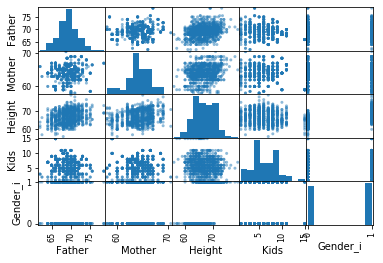

In [13]:
galton_df.loc[galton_df["Gender"] == 'F', 'Gender_i'] = 0
galton_df.loc[galton_df["Gender"] == 'M', 'Gender_i'] = 1

_ = pd.plotting.scatter_matrix(galton_df, diagonal="hist")

### Linear Regression Model #1

From the summary of the results of fitting the model, we see that there are clear effects for Father's Height, Mother's Height, and Gender, but not such a clear effect for Number of Siblings.

In the Number of Siblings case, we see that the standard error is very close to the size of the estimate so basically this distribution is very close to 0 and includes 0, so we may want to build a model without this variable. This is because models which have so called "chimera variables" tend to increase predictive variance.

In [14]:
x = galton_df[["Father", "Mother", "Gender_i", "Kids"]].values
const_col = np.ones((x.shape[0], 1))
X = np.hstack((x, const_col))

y = galton_df[["Height"]]

X.shape, y.shape

((898, 5), (898, 1))

In [15]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     398.1
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          9.09e-197
Time:                        16:25:50   Log-Likelihood:                -1960.1
No. Observations:                 898   AIC:                             3930.
Df Residuals:                     893   BIC:                             3954.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3983      0.030     13.472      0.000       0.340       0.456
x2             0.3210      0.031     10.269      0.000       0.260       0.382
x3             5.2099      0.144     36.125      0.000       4.927       5.493
x4            -0.0438      0.027     -1.612      0.107      -0.097       0.010
const         16.1877      2.794      5.794      0.000      10.704      21.671
==============================================================================
Omnibus:                       12.177   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.265
Skew:                          -0.149   Prob(JB):                     0.000294
Kurtosis:                       3.588   Cond. No.                     3.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linear Regression Model #2

We build another model, this time without the Kids column.

Results indicate that all the variables of the model have strong effects. R-squared does not seem to have changed much, but becuase all the model variables have strong effects, we will prefer this model.

In [16]:
x = galton_df[["Father", "Mother", "Gender_i"]].values
const_col = np.ones((x.shape[0], 1))
X = np.hstack((x, const_col))

y = galton_df[["Height"]]

X.shape, y.shape

((898, 4), (898, 1))

In [17]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     529.0
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          1.33e-197
Time:                        16:25:50   Log-Likelihood:                -1961.4
No. Observations:                 898   AIC:                             3931.
Df Residuals:                     894   BIC:                             3950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4060      0.029     13.900      0.000       0.349       0.463
x2             0.3215      0.031     10.277      0.000       0.260       0.383
x3             5.2260      0.144     36.289      0.000       4.943       5.509
const         15.3448      2.747      5.586      0.000       9.954      20.736
==============================================================================
Omnibus:                       11.936   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.952
Skew:                          -0.145   Prob(JB):                     0.000344
Kurtosis:                       3.585   Cond. No.                     3.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 95% probability interval for the difference in heights between boys and girls

Results indicate that a male child is on average 5.2 inches taller than female child.

Marginal distribution for the slope parameter for gender will be a t-distribution with 894 degrees of freedom. From the summary we can see it is (4.943, 5.509). So it shows that boys are going to be on average about 5 inches taller than girls.

In [18]:
height_diff_lb = 5.2260 - 0.144 * stats.t.ppf(0.975, 894)
height_diff_ub = 5.2260 + 0.144 * stats.t.ppf(0.975, 894)
(height_diff_lb, height_diff_ub)

(4.943382566373184, 5.508617433626816)

### 95% prediction intervals

Bayesian analysis will yield the same values as frequentist analysis.

When father's height is 68 inches and mother's height is 64 inches, 95% interval for predicted heights for child are:
* if male, between 64.52 and 72.98 inches, with mean 68.75 inches
* if female, between 59.29 and 67.76 inches, with mean 63.53 inches

In [19]:
pi_male = results.get_prediction([68, 64, 1, 1])
pi_male.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,68.752906,0.105566,68.545719,68.960092,64.519707,72.986105


In [20]:
pi_female = results.get_prediction([68, 64, 0, 1])
pi_female.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,63.526954,0.110291,63.310495,63.743413,59.293291,67.760617
